In [200]:
import functools
import itertools
import importlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from matplotlib import ticker

from bullinger import chronogram
from bullinger import cohort
from bullinger import intervals
from bullinger import plot
from bullinger import video
from bullinger import analysis

intervals = importlib.reload(intervals)
video = importlib.reload(video)
chronogram = importlib.reload(chronogram)
cohort = importlib.reload(cohort)
plot = importlib.reload(plot)
analysis = importlib.reload(analysis)

In [201]:
folder = '/home/olivier/dev/data/laura_codage/'
c = cohort.Cohort(folder, num_workers=20)


In [136]:
print(c.num_annotations, 'annotations in', len(c), 'videos')

3656 annotations in 197 videos


In [4]:
c.summary

video_id  baby  duration
semester group                          
1.0      AD           51    10  5351.814
         TD           49    10  4580.886
2.0      AD           49    10  4993.122
         TD           48    10  3979.307

/home/olivier/dev/bullinger/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/olivier/dev/bullinger/bullinger/chronogram.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(list(yticks.keys())), fontsize=18)


array(['parle', 'init', 'mama', 'rep', 'touch', 'sons', 'chant', 'obj',
       'voc'], dtype=object)

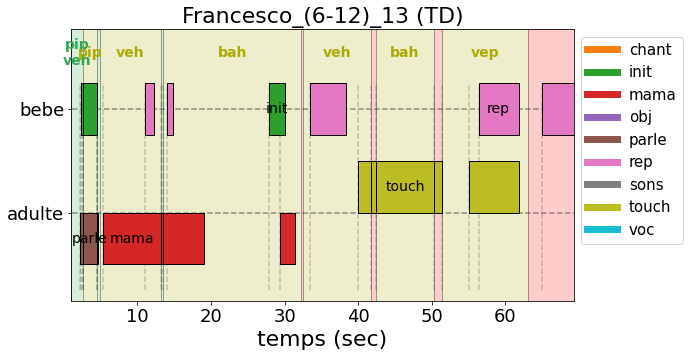

In [379]:
chronogram = importlib.reload(chronogram)
chronogram.plot(c[0], tags=c.interaction_tags)
c.actors_df.tag.unique()


# Comment les bébés sont-ils stimulés et comment répondent-ils ?

In [202]:
df = c.aggregate(lambda v: v.summary)
df

duration           stimulation            response          
                      mean       sem        mean       sem      mean       sem
semester group                                                                
1.0      AD     102.921686  4.251422    0.445214  0.041393  0.154949  0.028767
         TD      91.113837  3.143638    0.528101  0.039871  0.339874  0.046086
2.0      AD     101.099918  4.537823    0.492116  0.048187  0.221554  0.033815
         TD      82.186750  3.708622    0.545194  0.043936  0.441946  0.047085

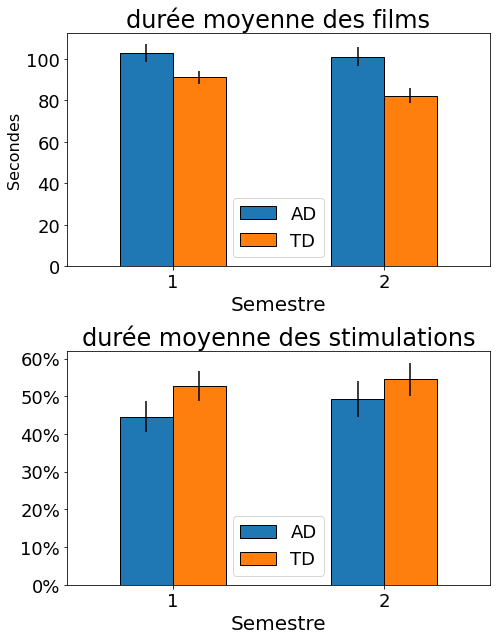

In [203]:
fig, axes = plt.subplots(2, 1, figsize=(7, 9))
plot.plot_agg(df, metric='duration', ax=axes[0], rot=0, title='durée moyenne des films')
plot.plot_agg(df, metric='stimulation', ax=axes[1], rot=0, title='durée moyenne des stimulations')
# _ = plot.plot_agg(df, metric='response', ax=axes[2], rot=0, title='durée moyenne des réponses')
for ax in axes:
    ax.set_xlabel('Semestre', fontsize=20)
    ax.set_ylabel(None)
axes[0].set_ylabel('Secondes', fontsize=16)
plt.tight_layout()

<AxesSubplot:title={'center':'durée moyenne des stimulations'}, xlabel='semester', ylabel='result'>

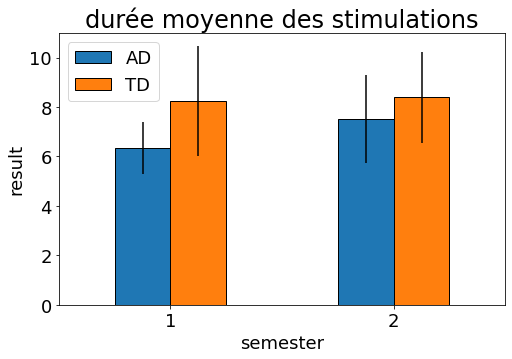

In [204]:
df = c.aggregate(analysis.to_series(lambda v: v.stimulations.duration.mean()))
plot.plot_agg(df, metric='result', rot=0, title='durée moyenne des stimulations')

## Types de stimulations

mama               parle               touch            \
                    mean       sem      mean       sem      mean       sem   
semester group                                                               
1.0      AD     0.559435  0.054536  0.098185  0.027173  0.090317  0.034598   
         TD     0.487479  0.046818  0.257889  0.041572  0.076037  0.024224   
2.0      AD     0.313482  0.044933  0.346603  0.051096  0.021515  0.010993   
         TD     0.356948  0.047993  0.299984  0.050206  0.093674  0.031360   

                   chant                sons                 obj            
                    mean       sem      mean       sem      mean       sem  
semester group                                                              
1.0      AD     0.035708  0.022163  0.043671  0.013103  0.094253  0.035114  
         TD     0.040479  0.016227  0.046266  0.013637  0.071442  0.026735  
2.0      AD     0.032678  0.013766  0.092931  0.026818  0.151975  0.035761  
         TD     0.048236  0.026171  0.067932  0.015628  0.112392  0.030651

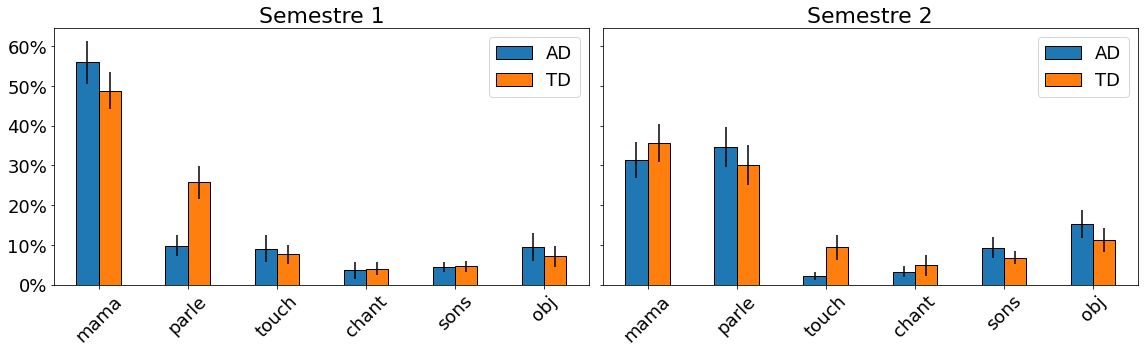

In [205]:
v = c[20]
def tags(v):
    df = v.visible
    df = df[(df.actor.str.startswith(v._adult)) & (df.tag != 'rep')]
    df = df.groupby('tag').agg({'duration': np.sum}) 
    df /= df.duration.sum()
    return df.transpose().iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
df = c.aggregate(tags, fillnans=0.0)
plot.per_semester(df, rot=45, axes=axes)
for i, ax in enumerate(axes):
    ax.set_xlabel(None)
    ax.set_title(f"Semestre {i+1}", fontsize=22)
plt.tight_layout()
df

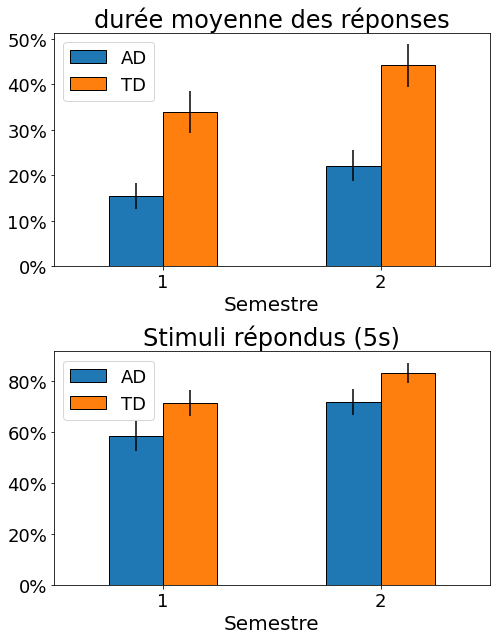

In [553]:
df = c.aggregate(lambda v: v.summary)
fig, axes = plt.subplots(2, 1, figsize=(7, 9))
plot.plot_agg(df, metric='response', ax=axes[0], rot=0, title='durée moyenne des réponses')

agg_df = c.aggregate(functools.partial(analysis.response_rate, tolerance=5))
plot.plot_agg(agg_df, 'result', ax=axes[1], rot=0, title=f'Stimuli répondus ({tol}s)')
for ax in axes:
    ax.set_ylabel(None)
    ax.set_xlabel("Semestre", fontsize=20)
plt.tight_layout()

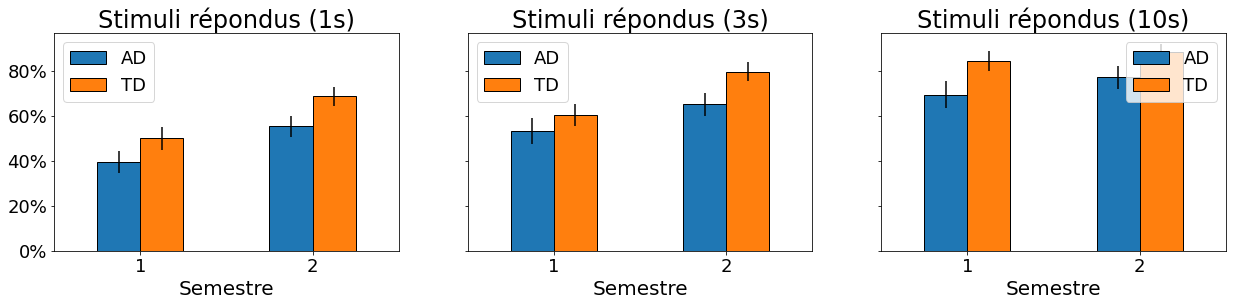

In [382]:
fig, axes = plt.subplots(1, 3, figsize=(21, 4), sharey=True)
for ax, tol in zip(axes, [1, 3, 10]):
    agg_df = c.aggregate(functools.partial(analysis.response_rate, tolerance=tol))
    plot.plot_agg(agg_df, 'result', ax=ax, rot=0, title=f'Stimuli répondus ({tol}s)')
    ax.set_ylabel(None)
    ax.set_xlabel("Semestre", fontsize=20)

# Le bébé est-il à l'initiative de l'interaction ?

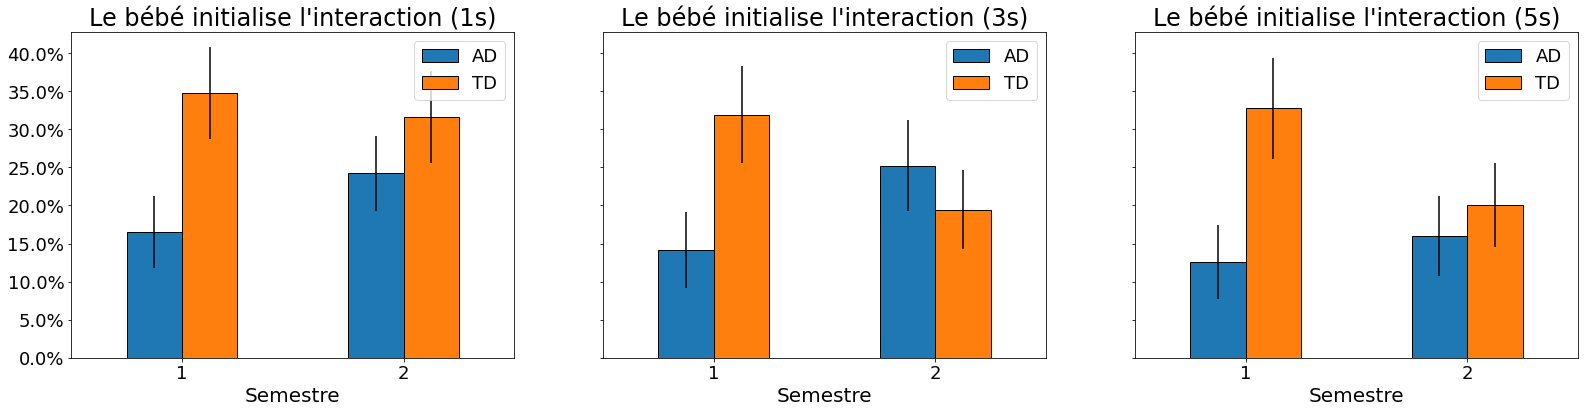

In [383]:
fig, axes = plt.subplots(1, 3, figsize=(3*9, 6), sharey=True)
for ax, tol in zip(axes, [1, 3, 5]):
    df = c.aggregate(functools.partial(analysis.starts, tolerance=tol), fillnans=None)
    plot.plot_agg(df, 'result', ax=ax, rot=0, title=f'Le bébé initialise l\'interaction ({tol}s)')
    ax.set_ylabel(None)
    ax.set_xlabel("Semestre", fontsize=20)

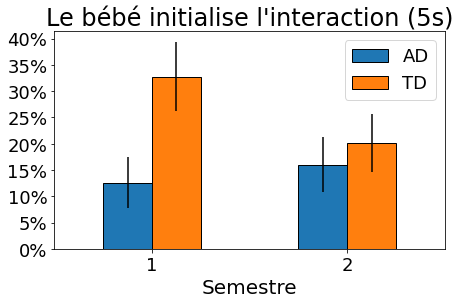

In [565]:
df = c.aggregate(functools.partial(analysis.starts, tolerance=5), fillnans=None)
fig = plt.figure(figsize=(7, 4))
ax = plt.gca()
plot.plot_agg(df, 'result', ax=ax, rot=0, title=f'Le bébé initialise l\'interaction ({5}s)')
ax.set_ylabel(None)
ax.set_xlabel("Semestre", fontsize=20)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=0))

# Tour de parole

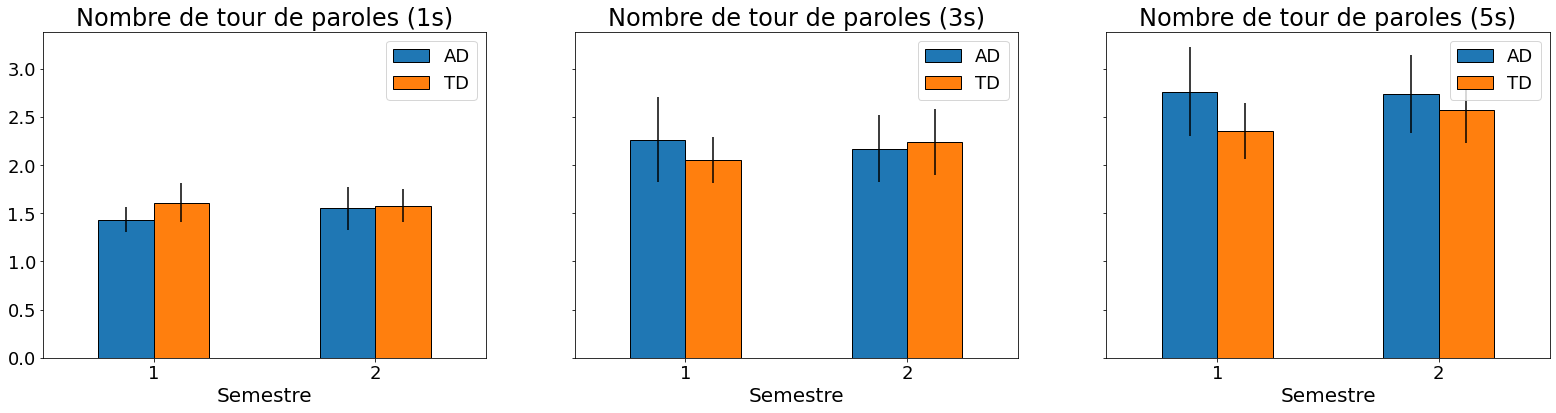

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(3*9, 6), sharey=True)
for ax, tol in zip(axes, [1, 3, 5]):
    df = c.aggregate(functools.partial(analysis.turn_taking, tolerance=tol), fillnans=None)
    plot.plot_agg(df, 'result', ax=ax, rot=0, title=f'Nombre de tour de paroles ({tol}s)')
    ax.set_ylabel(None)
    ax.set_xlabel("Semestre", fontsize=20)

Text(0.5, 0, 'Semestre')

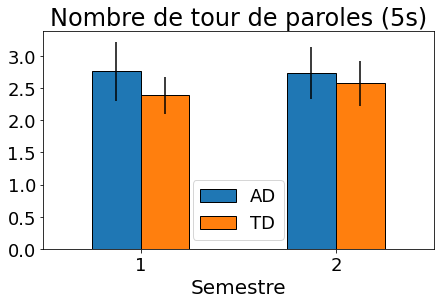

In [564]:
tol = 5
df = c.aggregate(functools.partial(analysis.turn_taking, tolerance=tol), fillnans=None)
fig = plt.figure(figsize=(7, 4))
ax = plt.gca()
plot.plot_agg(df, 'result', ax=ax, rot=0, title=f'Nombre de tour de paroles ({tol}s)')
ax.set_ylabel(None)
ax.set_xlabel("Semestre", fontsize=20)

# Durée des reponses

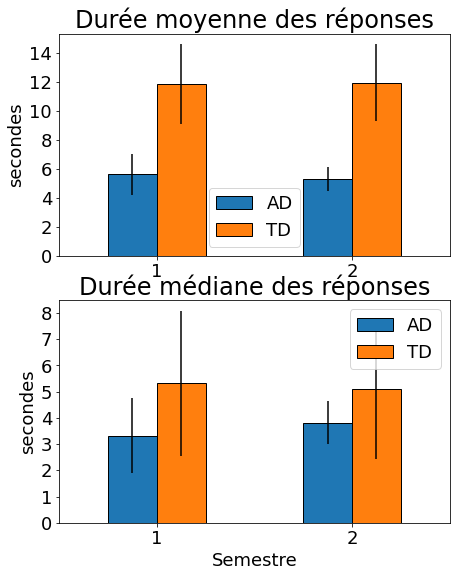

In [206]:
fig, axes = plt.subplots(2, 1, figsize=(7, 9))
for ax, median, name in zip(axes, [False, True], ['moyenne', 'médiane']):
    df = c.aggregate(analysis.average_response_duration, median=median)
    plot.plot_agg(df, 'result', ax=ax, rot=0, title=f'Durée {name} des réponses')
    ax.set_ylabel('secondes')
    ax.set_xlabel(None if name == 'moyenne' else 'Semestre', fontsize=18)

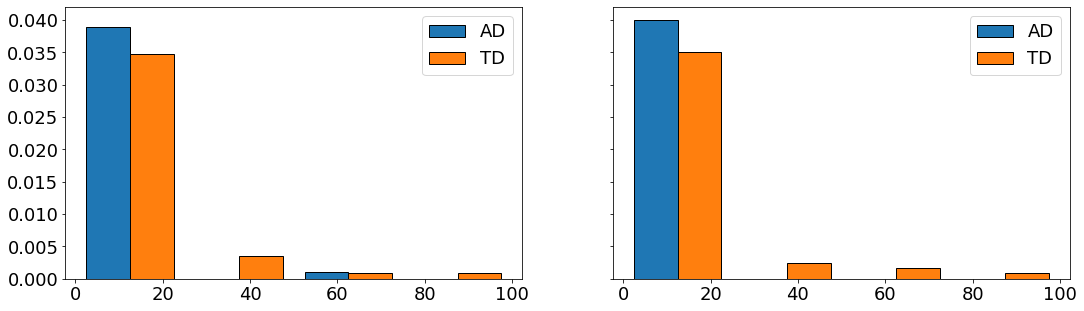

In [207]:
df = c.apply(analysis.average_response_duration)

groups = ['AD', 'TD']
semesters = [1, 2]
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)
for ax, s in zip(axes, semesters):
    pos = np.linspace(0, 100, 5)
    values = [df[(df.group == group) & (df.semester == s)].result
              for group in groups]
    _ = ax.hist(values, bins=pos, ec='k', label=groups, density=True)
    plot.readable_ax(ax)

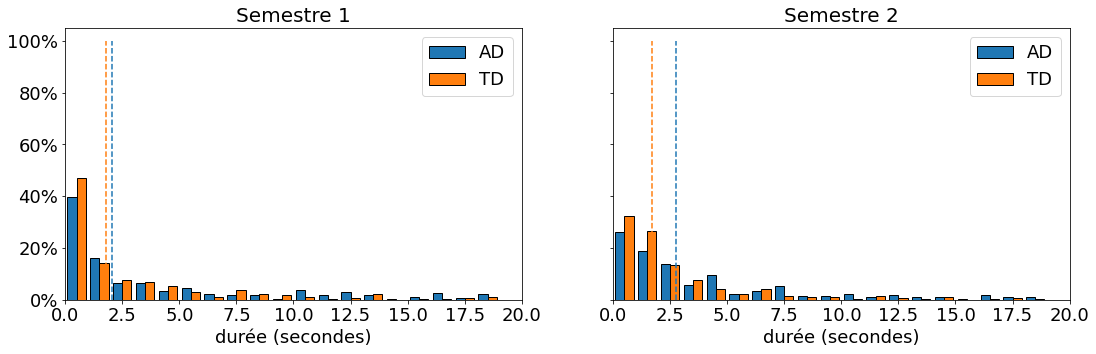

In [203]:
def plot_response_distribution(c, num_supports=None):
    df = c.df
    if num_supports is not None:
        df = df[df.num_supports==num_supports]
    max_duration = 120
    groups = ['AD', 'TD']
    
    _, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)
    for ax, s in zip(axes, [1, 2]):
        sub_df = df[(df.semester == s) & (df.duration < max_duration)]
        vs = []    
        for group in groups:
            values = sub_df[sub_df.group == group].duration.values
            vs.append(values)        

        mus = np.array([np.median(v) for v in vs])
        ps = ax.plot(np.tile(mus, 2).reshape((2, -1)),
                     np.repeat(np.array([0, 1.0]), 2).reshape(2, -1),
                     linestyle='--')
        d, _, _ = ax.hist(vs, density=True, bins=np.arange(20), label=groups, ec='k', color=[p.get_color() for p in ps])
        ax.set_xlim(0, 20)
        ax.legend(fontsize=15)
        ax.set_title(f'Semestre {s}', fontsize=20)
        ax.set_xlabel('durée (secondes)', fontsize=18)
    for ax in axes:
        plot.readable_ax(ax)
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=0))
        
vs = plot_response_distribution(c, 2)

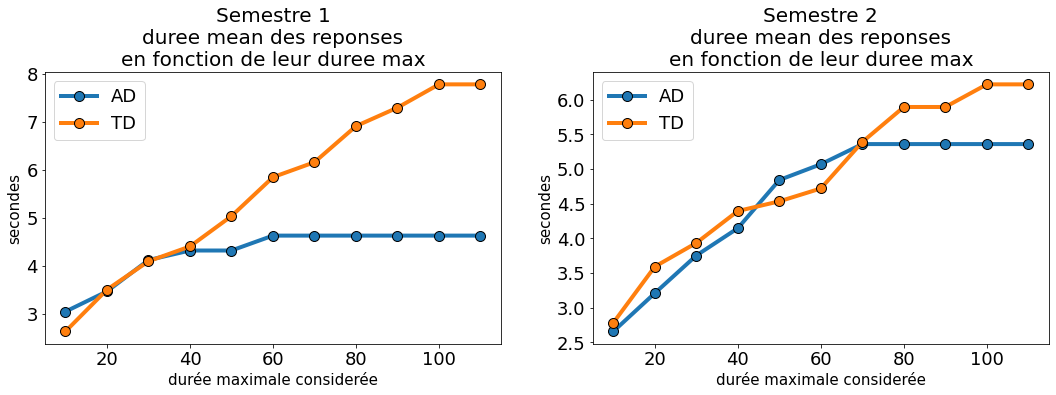

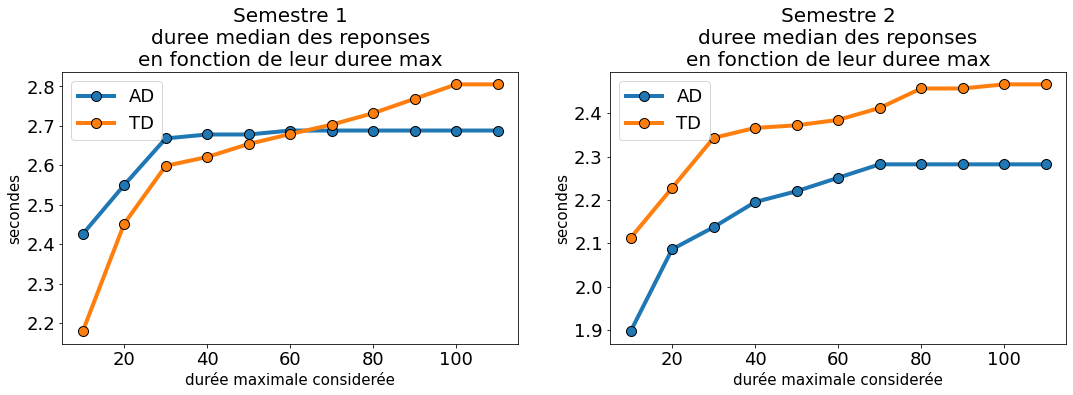

In [204]:
def plot_mean_duration_evolution(c, agg_func=np.mean):
    df = c.responses
    cmap = plt.get_cmap('tab10')
    _, axes = plt.subplots(1, 2, figsize=(18, 5))
    for ax, s in zip(axes, [1, 2]):
        for i, group in enumerate(['AD', 'TD']):
            values = []
            sub_df = df[(df.group == group) & (df.semester == s)]
            thresholds = np.arange(10, 120, 10)
            for max_duration in thresholds:
                durations = sub_df[sub_df.duration < max_duration].duration
                values.append(agg_func(durations))
            ax.plot(thresholds, values, label=group,
                    lw=4, marker='o', markersize=10, markeredgecolor='k', color=cmap(0.1*i))
        ax.legend(fontsize=15)
        ax.set_title(f'Semestre {s}\nduree {agg_func.__name__} des reponses\nen fonction de leur duree max', fontsize=20)
        ax.set_ylabel("secondes",fontsize=15)
        ax.set_xlabel("durée maximale considerée",fontsize=15)
        plot.readable_ax(ax)
        
plot_mean_duration_evolution(c, agg_func=np.mean)
plot_mean_duration_evolution(c, agg_func=np.median)

# Le bebe commence l interaction mais on lui repond pas

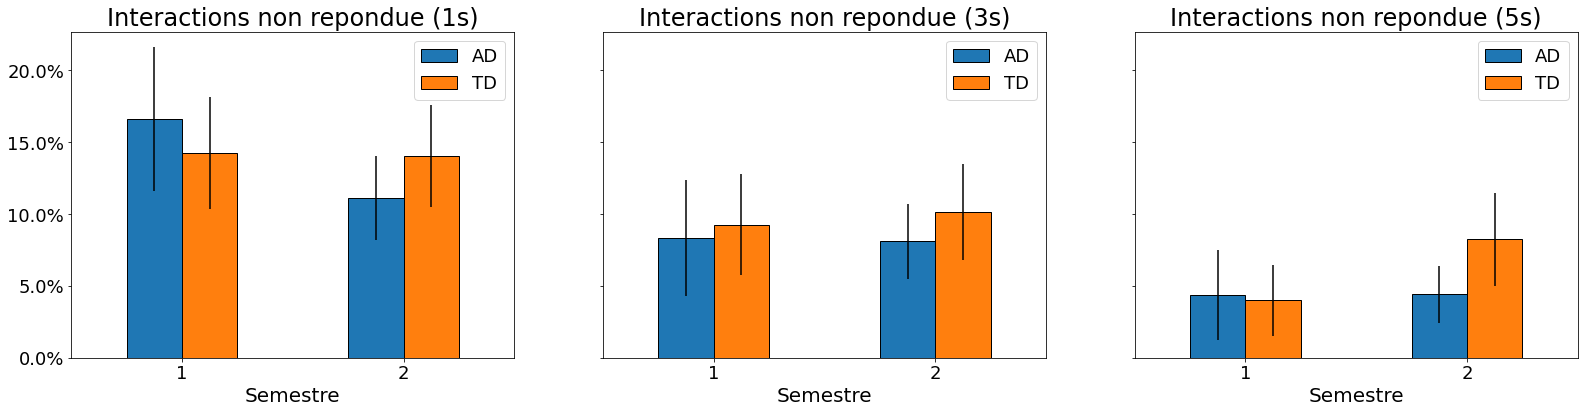

In [237]:
fig, axes = plt.subplots(1, 3, figsize=(3*9, 6), sharey=True)
for ax, tol in zip(axes, [1, 3, 5]):
    df = c.aggregate(functools.partial(analysis.unanswered_init, tolerance=tol))
    plot.plot_agg(df, 'result', ax=ax, rot=0, title=f'Interactions non repondue ({tol}s)')    
    ax.set_ylabel(None)
    ax.set_xlabel("Semestre", fontsize=20)

# Le nombre d'appuis influencent-ils la reponse du bébé ?

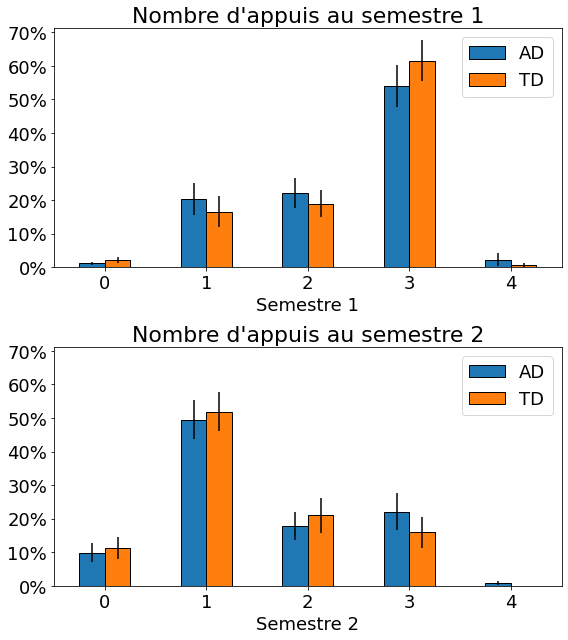

In [208]:
_, axes = plt.subplots(2, 1, figsize=(8, 9), sharey=True)
df = c.aggregate(analysis.support_duration, median=False, fillnans=0.0)
axes = plot.per_semester(df.iloc[:, :-2], axes=axes, rot=0)
for i, ax in enumerate(axes):
    ax.set_title(f'Nombre d\'appuis au semestre {i+1}', fontsize=22)
plt.tight_layout()

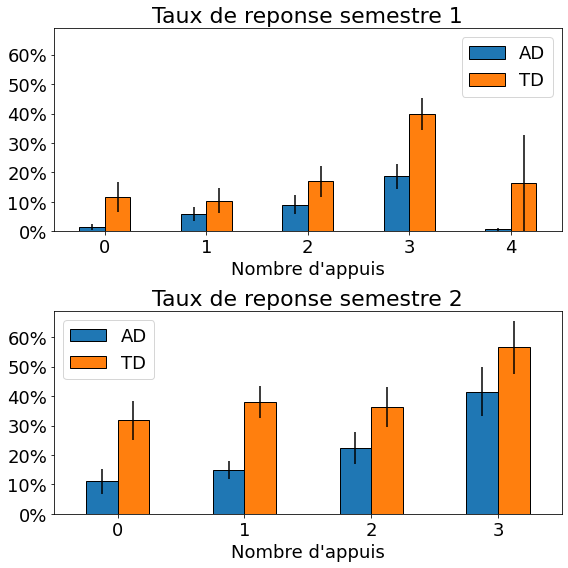

In [572]:
_, axes = plt.subplots(2, 1, figsize=(8, 8), sharey=True)
axes = plot.per_semester(
    c.aggregate(analysis.responses_per_supports, median=False, fillnans=None),
    axes=axes, rot=0)
for i, ax in enumerate(axes):
    ax.set_title(f'Taux de reponse semestre {i+1}', fontsize=22)
    ax.set_xlabel(f'Nombre d\'appuis')
plt.tight_layout()

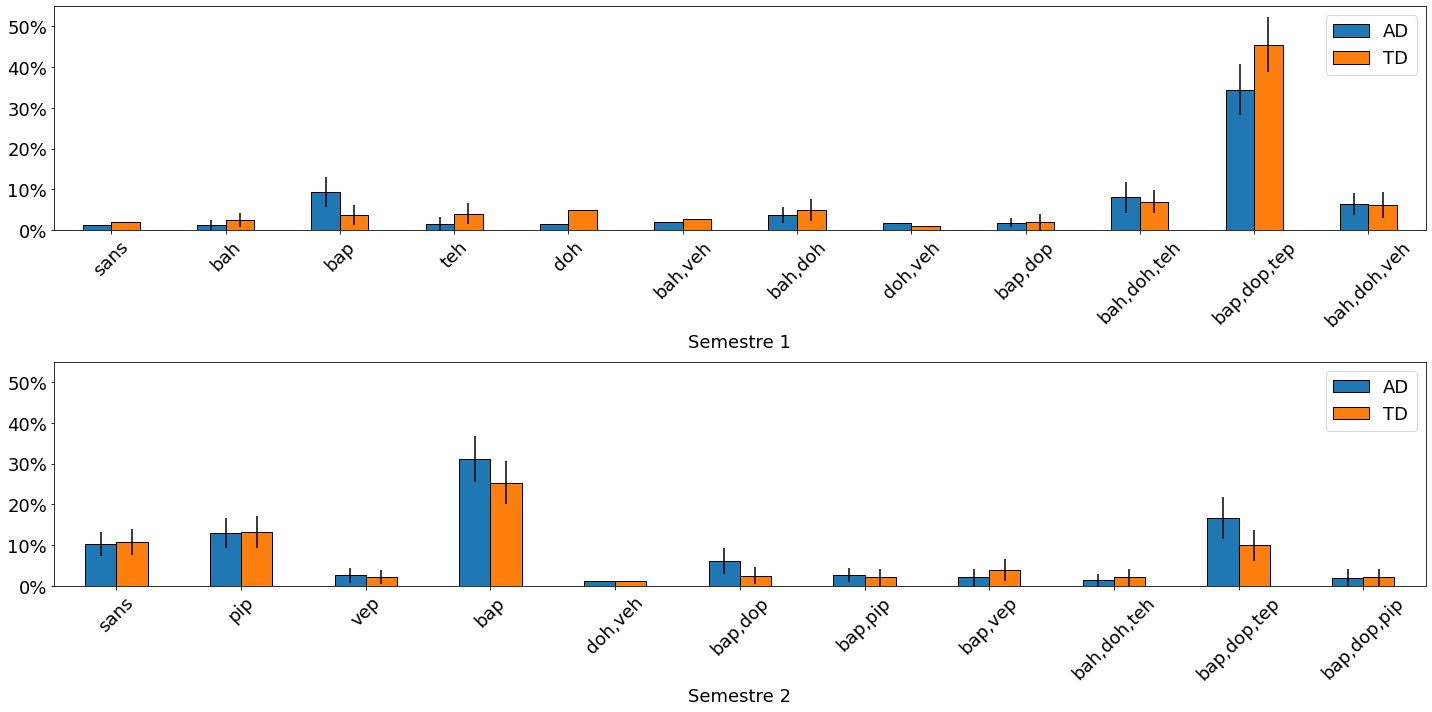

In [209]:
def support_type(v: video.Video) -> pd.Series:    
    df = v.visible
    df = df.groupby('context').agg(lambda x: intervals.from_dataframe(x).length)[['duration']]
    df['duration'] /= df.duration.sum()
    df = pd.pivot_table(df, 'duration', index='context').transpose()
    return df.iloc[0]

# support_type(c[23])
_, axes = plt.subplots(2, 1, figsize=(20, 10), sharey=True)
df = c.aggregate(support_type, fillnans=0.0)
level0 = sorted(df.columns.get_level_values(0).values.tolist(), key=lambda x: x.count(',') - 2 * int(x=='sans'))
level1 = df.columns.get_level_values(1)
df = df[pd.MultiIndex.from_arrays([level0, level1])]
df = df.transpose()
df = df[df.loc[:, :] > 0.01].dropna(axis=0, how='all').transpose()
axes = plot.per_semester(df, axes=axes, rot=45)
plt.tight_layout()

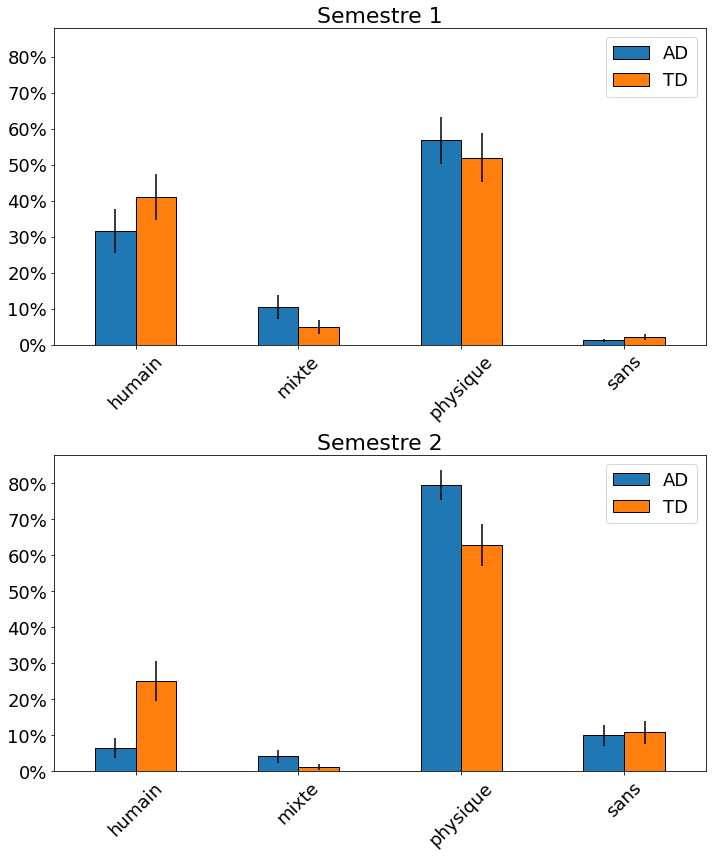

In [210]:
v = c[15]
df = v.df.copy()
df['support_type'] = v.df.context.apply(lambda x: ','.join(sorted(a[-1] for a in x.split(','))))

def get_simple_type(s):
    ts = sorted(a[-1] for a in s.split(','))
    types = {'h': 'humain', 'v': 'invisible', 'p': 'physique', 's': 'sans'}
    if ts[0] == ts[-1]:
        return types.get(ts[0], '?')
    return 'mixte'
    

def simple_type(v):
    df = v.context_df
    df = df[df.context != 'inv']
    df['type'] = df.context.apply(get_simple_type)
    values =  df.groupby('type').agg({'duration': np.sum})
    values /= values.duration.sum()
    return values.transpose().iloc[0]

df = c.aggregate(simple_type, fillnans=0.0)
_, axes = plt.subplots(2, 1, figsize=(10, 12), sharey=True)
plot.per_semester(df, rot=45, axes=axes)
for i, ax in enumerate(axes):
    ax.set_title(f'Semestre {i+1}', fontsize=22)
    ax.set_xlabel(None)
plt.tight_layout()

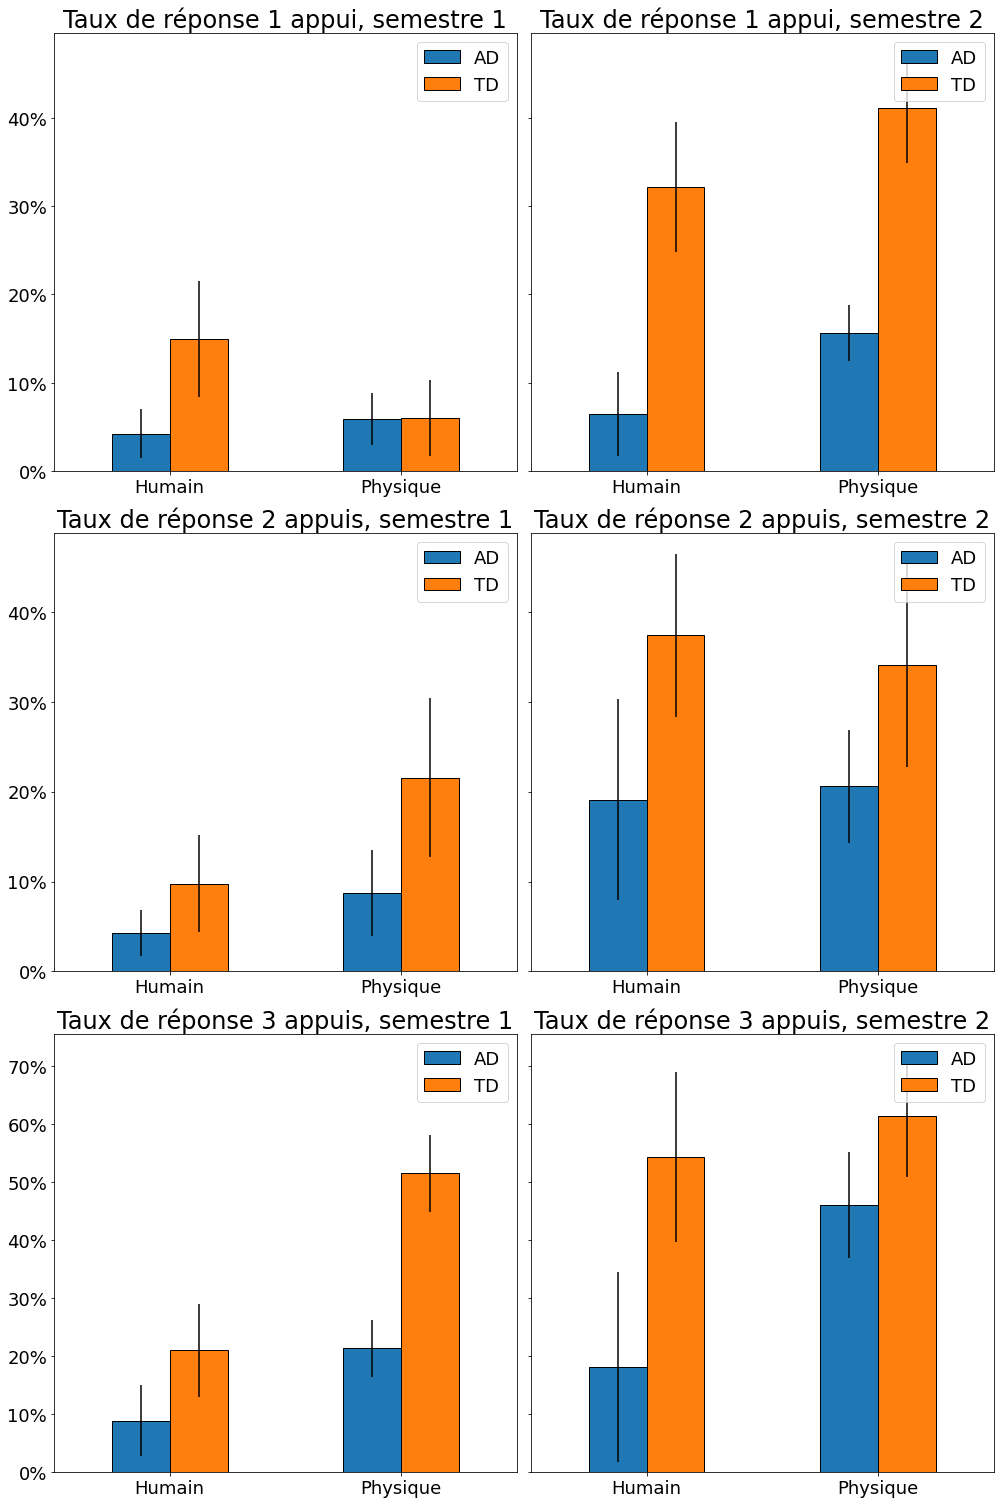

In [211]:
def support_type_response_fn(v, num_supports=3):
    v.df['support_type'] = v.df.context.apply(lambda x: ','.join(sorted(a[-1] for a in x.split(','))))
    df = pd.pivot_table(v.responses_per(groupby='support_type'), 'relative', index='support_type')
    df = df.transpose()
    
    def cond_fn(col):
        if num_supports == 0:
            return col == 's'
        if num_supports == 1:
            return len(col) == 1 and col != 's'
        return (num_supports == col.count(',') + 1) and (col.split(',')[0] == col.split(',')[-1])
   
    df = df.drop(columns=list(filter(lambda col: not cond_fn(col), df.columns)))
    if df.shape[0]:
        return df.iloc[0]

fig, axes = plt.subplots(3, 2, figsize=(2*7, 3*7), sharey='row')
for row, num in zip(axes, range(1, 4)):
    df = c.aggregate(functools.partial(support_type_response_fn, num_supports=num)).dropna(axis=1)
    plot.per_semester(df, axes=row, rot=0)
    for i, ax in enumerate(row):
        ax.set_xticklabels(['Humain', 'Physique'])
        ax.set_xlabel(None)
        ax.set_title(f'Taux de réponse {num} appui{"s"*(num>1)}, semestre {i+1}', fontsize=24)
plt.tight_layout()

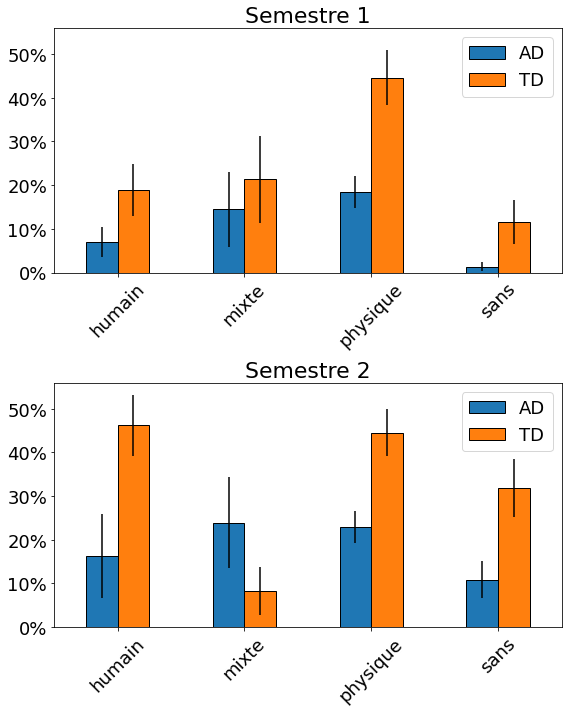

In [212]:
def get_simple_type(s):
    ts = sorted(a[-1] for a in s.split(','))
    types = {'h': 'humain', 'v': 'invisible', 'p': 'physique', 's': 'sans'}
    if ts[0] == ts[-1]:
        return types.get(ts[0], '?')
    return 'mixte'
    

def response_per_type(v):
    df = v.df
    df['type'] = df.context.apply(get_simple_type)
    df = v.responses_per(groupby='type')
    df = pd.pivot_table(df, 'relative', index='type')
    df = df.transpose()
    if df.shape[0]:
        return df.iloc[0]

df = c.aggregate(response_per_type, fillnans=None)
_, axes = plt.subplots(2, 1, figsize=(8, 10), sharey=True)
plot.per_semester(df, rot=45, axes=axes)
for i, ax in enumerate(axes):
    ax.set_title(f'Semestre {i+1}', fontsize=22)
    ax.set_xlabel(None)
plt.tight_layout()

# Les bebes AD sont-ils moins filmes ?

<AxesSubplot:title={'center':'Le bébé est hors champ'}, xlabel='semester', ylabel='invisible'>

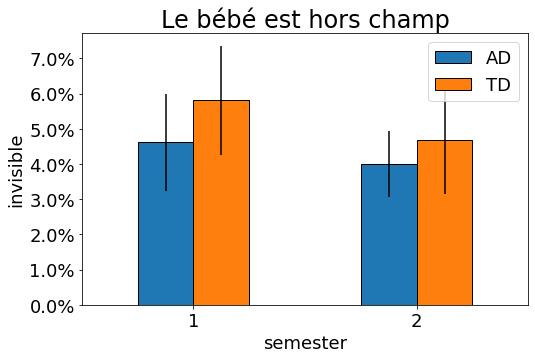

In [132]:
plot.plot_agg(c.aggregate(analysis.invisible_time, fillnans=0.0), 'invisible', rot=0, title='Le bébé est hors champ')

4 sequences d'interaction


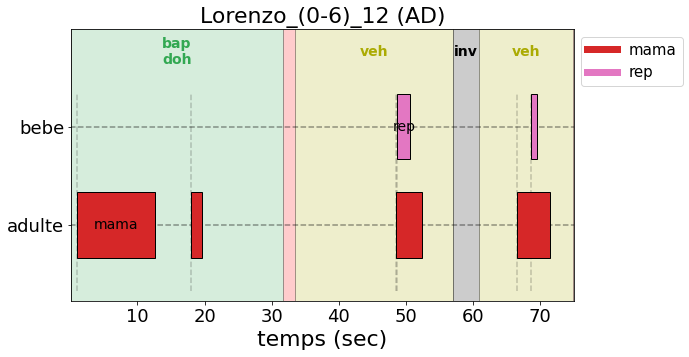

In [1023]:
chronogram.plot(c[9])
print(len(c[9].sequences(tolerance=5)), 'sequences d\'interaction')

# Repeated movements

In [413]:
print(c.df[c.df.actor.str.startswith('rme')].video_id.unique().size, 'videos avec RME')

28 videos avec RME


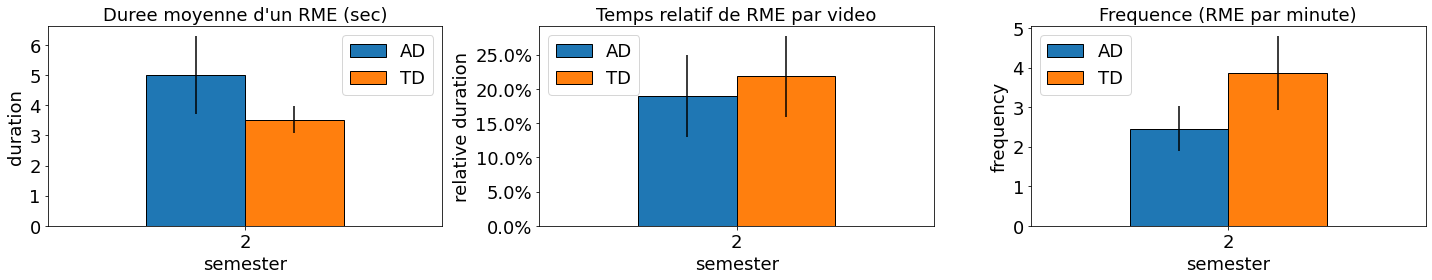

In [414]:
def repeated_duration(v: video.Video):
    df = v.df
    df = df[df.actor.str.startswith('rme')]
    exists = df.duration.sum() > 0
    return pd.Series({
        'duration': df.duration.mean(),
        'relative duration': df.duration.sum() / v.duration if exists else np.nan,
        'frequency': df.duration.count() / v.duration * 60 if exists else np.nan,
    })

df = c.aggregate(repeated_duration)
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
plot.plot_agg(df, 'duration', rot=0, ax=axes[0])
plot.plot_agg(df, 'relative duration', rot=0, ax=axes[1])
plot.plot_agg(df, 'frequency', rot=0, ax=axes[2], percentage=False)
axes[0].set_title('Duree moyenne d\'un RME (sec)', fontsize=18)
axes[1].set_title('Temps relatif de RME par video', fontsize=18)
axes[2].set_title('Frequence (RME par minute)', fontsize=18)
plt.tight_layout()

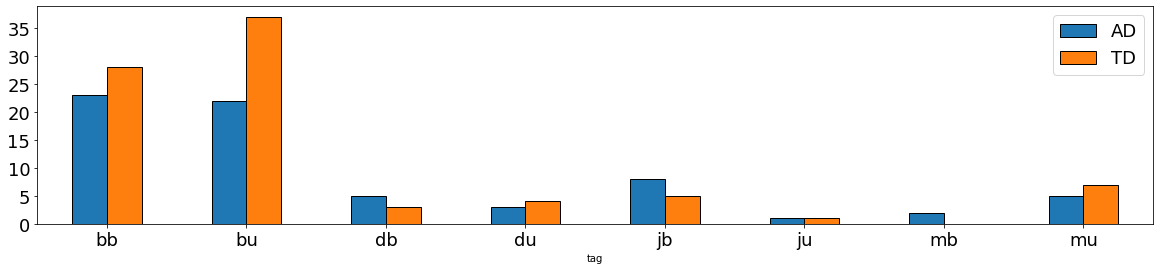

In [415]:
df = c.df[c.df.actor.str.startswith('rme')]
_, ax = plt.subplots(1, 1, figsize=(20, 4))
pd.pivot_table(df, 'duration', index='tag', columns=['group'], aggfunc='count').plot.bar(ec='k', ax=ax)
plot.readable_ax(ax)

<AxesSubplot:title={'center':'Claudio_(6-12)_09'}, xlabel='temps (sec)'>

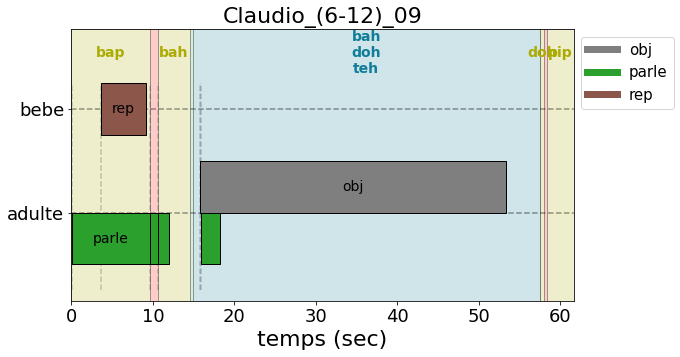

In [423]:
c.df[c.df.tag == 'db'].video_id.unique()
chronogram.plot(c['Claudio_(6-12)_09'])

In [402]:
def rme_breakdown(v):
    df = v.df
    return pd.pivot_table(df, 'duration', index='group', columns=['tag'], aggfunc=np.sum)

df = pd.concat([rme_breakdown(v) for v in c]).reset_index()
df.groupby('group').agg(['mean', 'sem'])

init                 mama                parle            \
           mean       sem       mean       sem       mean       sem   
group                                                                 
AD     5.889357  1.038983  29.422803  2.586733  21.938517  4.030469   
TD     6.210261  1.875960  26.046062  2.745201  19.203672  2.361504   

             rep              support            ...        db            \
            mean       sem       mean       sem  ...      mean       sem   
group                                            ...                       
AD     21.458608  2.416541  97.677949  2.907724  ...  11.06075  4.341101   
TD     33.461800  3.491652  84.560887  2.804284  ...       NaN       NaN   

           mb              du                 mu              voc      
         mean     sem    mean     sem       mean       sem   mean sem  
group                                                                  
AD     14.897  13.156  9.1685  4.3315  10.469667  3.751894  1.383 NaN  
TD        NaN     NaN     NaN     NaN        NaN       NaN    NaN NaN  

[2 rows x 40 columns]

# Etats d'eveil

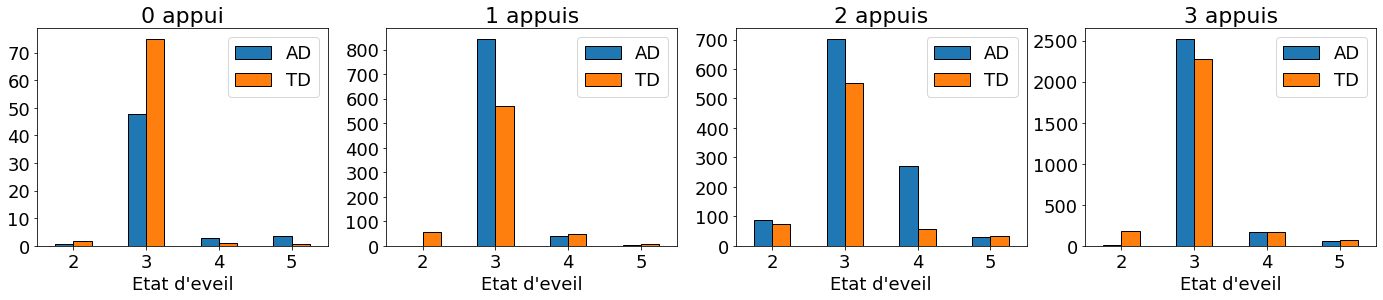

In [1306]:
# vid = c.df[c.df.actor == 'bebe bis'].video_id.unique().tolist()[4]
df = c[vid].df
df = c.df
df = df[df.actor == 'bebe bis']
df = df.groupby(['num_supports', 'tag', 'group']).agg({'duration': np.sum}).iloc[:-4, :]
supports = df.index.get_level_values('num_supports').unique()
fig, axes = plt.subplots(1, supports.shape[0], figsize=(6*supports.shape[0], 4))
for support, ax in zip(supports, axes):
    table = pd.pivot_table(df.loc[support], values='duration', index='tag', columns=['group'])
    table.plot.bar(rot=0, ec='k', ax=ax)
    ax.set_xlabel('Etat d\'eveil', fontsize=18)
    ax.set_title(f'{int(support)} appui' + 's' * bool(support), fontsize=22)
    plot.readable_ax(ax)    

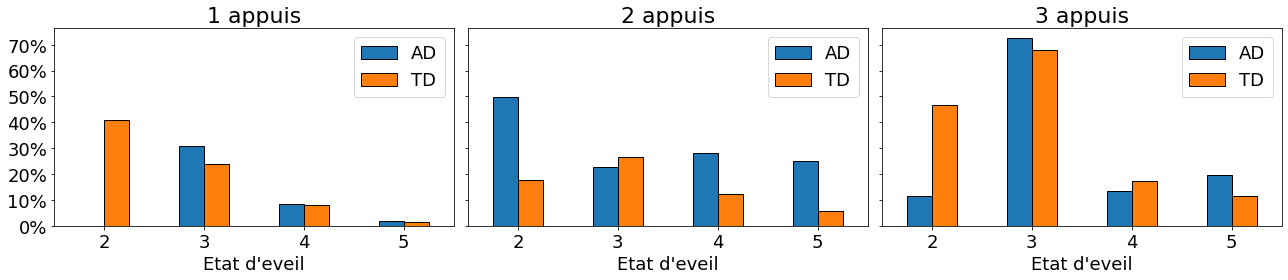

In [1353]:
def awake(v: video.Video) -> pd.Series:
    df = v.df
    df = df[df.actor == 'bebe bis']
    df = df.groupby(['num_supports', 'tag', 'group']).agg({'duration': np.sum})
    df.duration /= df.duration.sum()
    return df.reset_index()
    
df = pd.concat([awake(v) for v in c])
df = df.groupby(['num_supports', 'tag', 'group']).agg({'duration': ['mean', 'sem']}).iloc[8:-4]
supports = df.index.get_level_values('num_supports').unique()

# dd = pd.pivot_table(df.loc[2.0], values='duration', index='tag', columns=['group'])

fig, axes = plt.subplots(1, supports.shape[0], figsize=(6*supports.shape[0], 4), sharey=True)
for support, ax in zip(supports, axes):
    table = pd.pivot_table(df.loc[support], values='duration', index='tag', columns=['group'])
    table.loc[:, 'mean'].plot.bar(rot=0, ec='k', ax=ax)
    ax.set_xlabel('Etat d\'eveil', fontsize=18)
    ax.set_title(f'{int(support)} appui' + 's' * bool(support), fontsize=22)
    plot.readable_ax(ax)    
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=0))
plt.tight_layout()

In [426]:
def awake(v: video.Video) -> pd.Series:
    df = v.df
    df = df[(df.actor == 'bebe bis') & (df.duration > 0.1) & (df.num_supports < 5)]
    df.num_supports = df.num_supports.astype(int)
    df.tag = df.tag.astype(int)
    df = df.groupby(['num_supports', 'tag']).agg({'duration': np.sum})
    df.duration /= df.duration.sum()
    df = pd.pivot_table(df, values='duration', index='num_supports', columns=['tag']).fillna(0.0)
    result = np.zeros((5, 6))
    result[np.ix_(df.index, df.columns)] = df
    return result

m_ad = np.stack([awake(v) for v in c if v.group == 'AD' and v.semester == 1])
m_td = np.stack([awake(v) for v in c if v.group == 'TD' and v.semester == 1])

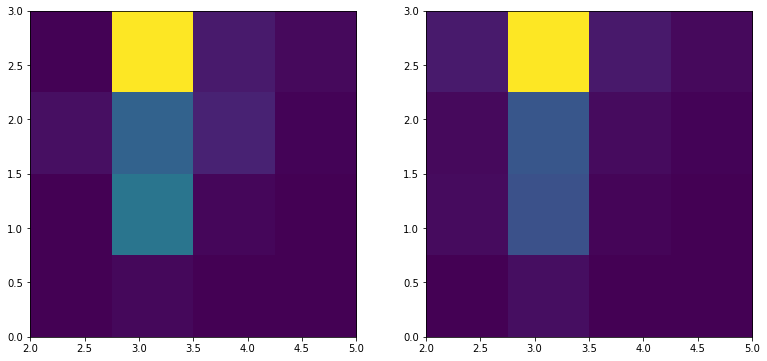

In [427]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
for m, ax in zip((m_ad, m_td), axes):
    ax.imshow(np.mean(m, axis=0)[:-1,2:], origin='lower', extent=[2,5,0,3])

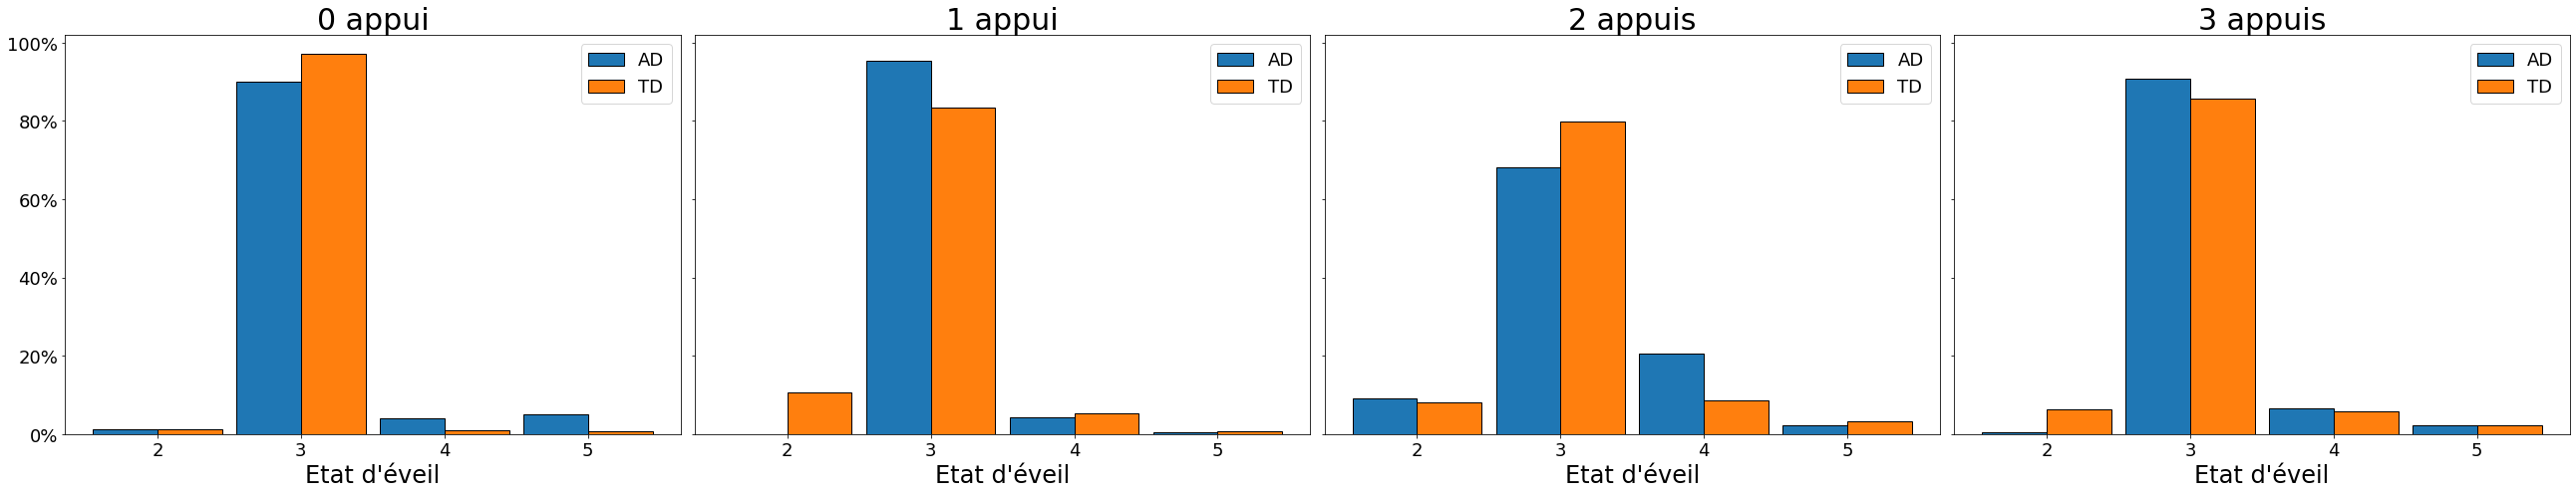

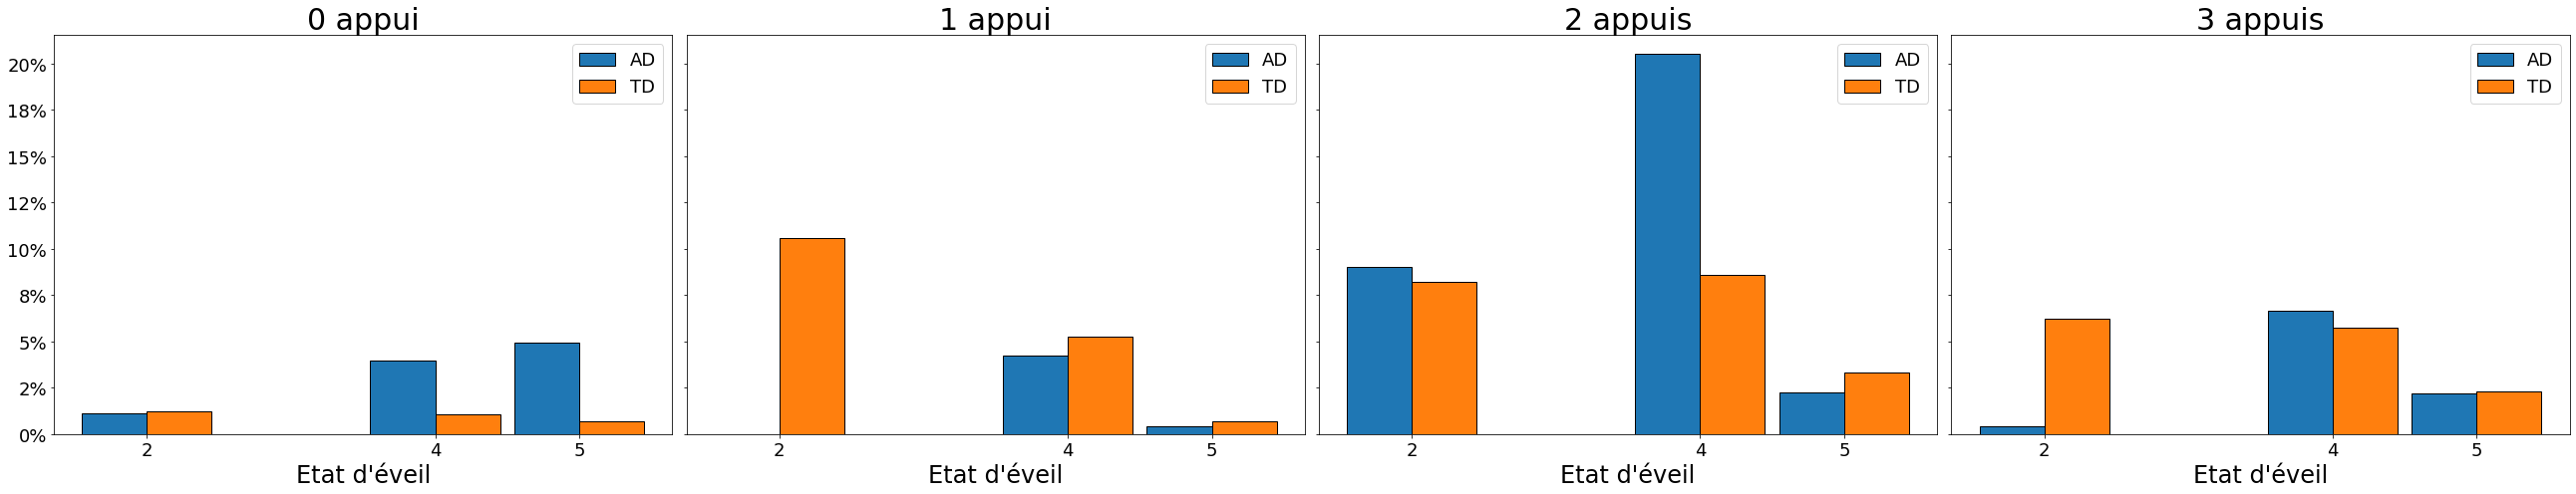

In [543]:
def plot_awake(c, not3=False):
    m_ad = np.stack([awake(v) for v in c if v.group == 'AD' and v.semester == 1])
    m_td = np.stack([awake(v) for v in c if v.group == 'TD' and v.semester == 1])
    
    fig, axes = plt.subplots(1, 4, figsize=(9*4, 7), sharey=True)
    for i, m in enumerate((m_ad, m_td)):
        group = 'TD' if i else 'AD'
        mu = np.mean(m, axis=0)[:-1,2:]
        mu /= np.sum(mu, axis=1)[:, np.newaxis]
        if not3:
            mu = mu[:, [0, 2, 3]]
        for j in range(4):
            ax = axes[j]
            states = np.arange(2, 6) if not not3 else np.array([2, 4, 5])
            ax.bar(states + 0.45*i, mu[j], width=0.45, ec='k', label=group)
            ax.set_title(f'{j} appui' + 's' * bool(j>1), fontsize=30)
            ax.set_xticks(states+0.225)
            ax.set_xticklabels(states)
    for ax in axes:
        ax.legend(fontsize=22)
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=0))
        ax.set_xlabel('Etat d\'éveil', fontsize=24)
        plot.readable_ax(ax)
    plt.tight_layout()
    
plot_awake(c, not3=False)
plot_awake(c, not3=True)

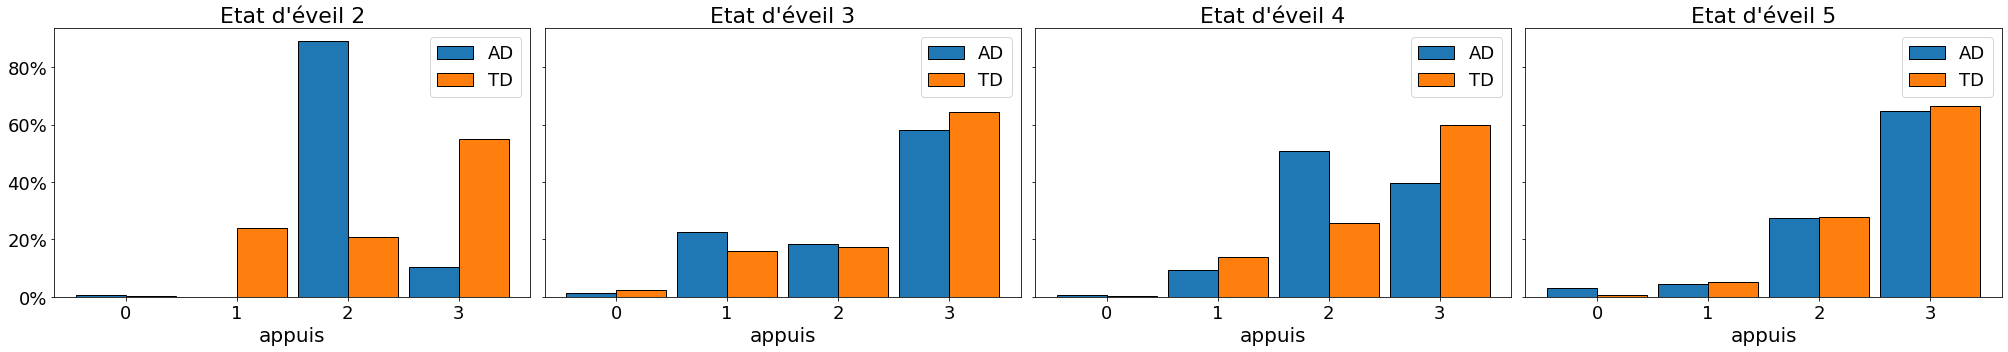

In [1566]:
import scipy
fig, axes = plt.subplots(1, 4, figsize=(7*4, 5), sharey=True)
for i, m in enumerate((m_ad, m_td)):
    group = 'TD' if i else 'AD'
    mu = np.mean(m, axis=0)[:-1,2:]
#     sem = scipy.stats.sem(m[:-1,2:], axis=0)
    cum = np.sum(mu, axis=0)[np.newaxis, :]
    mu /= cum
#     sem /= cum
    for j in range(4):
        ax = axes[j]
        states = np.arange(0, 4)
        ax.bar(states + 0.45*i, mu[:, j], width=0.45, ec='k', label=group)
        ax.set_title(f'Etat d\'éveil {j+2}', fontsize=22)
        ax.set_xticks(states+0.225)
        ax.set_xticklabels(states)
for ax in axes:
    ax.legend(fontsize=18)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=0))
    ax.set_xlabel('appuis', fontsize=20)
    plot.readable_ax(ax)
plt.tight_layout()

In [1562]:
m_ad.shape

(51, 5, 6)

In [1603]:
df = c.df
df = df[(df.tag == 'support')]
df.loc[:,'type'] = df.context.apply(lambda x: ''.join(sorted([c[-1] for c in x.split(',')])))
df = df[df.type != 's']

aa = df.type.apply(lambda x: x.count('p')).sum()
bb = df.type.apply(lambda x: x.count('h')).sum()

a = df.apply(lambda row: pd.Series({'d': row.duration * float('p' in row.type)}), axis=1).sum().d
b = df.apply(lambda row: pd.Series({'d': row.duration * float('h' in row.type)}), axis=1).sum().d

a / (a+b), aa / (aa+bb)

(0.6945200729128626, 0.5688720173535792)

# Reponse et etat d eveil 3

In [217]:
v = c[1]
def filter_awake(v, state):
    df = v.df
    awake = intervals.from_dataframe(df[(df.actor == 'bebe bis') & (df.tag == str(state))])
    df = intervals.filter_by(v.df, awake)
    df = df[(df.actor != 'bebe bis') & (df.context != 'support')]
    if df.shape[0]:
        return video.Video(df=df, process_context=False, fill_no_support=False)

videos3 = list(filter(None, [filter_awake(v, 3) for v in c]))

In [224]:
 def aggregate(videos, video_fn, median: bool = False, fillnans=None) -> pd.DataFrame:

    def fn(v):
        result = video_fn(v)
        if result is not None:
            for col in c.GROUPBY:
                if col not in result.index and col in v.df.columns:
                    result[col] = v.df[col].iloc[0]
        return pd.DataFrame(result)

    df = (pd.concat([fn(v) for v in videos], axis=1)
            .transpose()
            .reset_index()
            .drop(columns=['index']))
    for col in df.columns:
        if col not in c.GROUPBY:
            df[col] = df[col].astype(np.float)
    if fillnans is not None:
        df = df.fillna(0.0)

    funcs = ['mean', 'sem'] if not median else ['median', 'sem']
    return df.groupby(c.GROUPBY).agg(funcs)

df = aggregate(videos3, analysis.responses_per_supports)

0.0                 1.0                 2.0            \
                    mean       sem      mean       sem      mean       sem   
semester group                                                               
1.0      AD     0.006501  0.005718  0.078840  0.030207  0.111098  0.037633   
         TD     0.136415  0.063613  0.075852  0.038754  0.163026  0.062102   
         AD     0.013634  0.009491  0.057662  0.023103  0.089935  0.031520   
         TD     0.116172  0.049895  0.103874  0.041457  0.169943  0.052654   

                     3.0                 4.0            5.0      
                    mean       sem      mean       sem mean sem  
semester group                                                   
1.0      AD     0.171259  0.042630  0.011880       NaN  NaN NaN  
         TD     0.392688  0.056044  0.162835  0.162835  0.0 NaN  
         AD     0.186540  0.042629  0.005918  0.005918  NaN NaN  
         TD     0.398118  0.053858  0.162835  0.162835  0.0 NaN

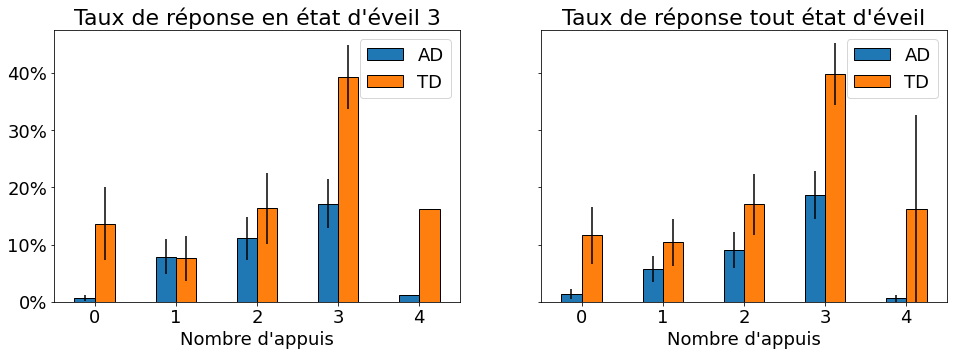

In [257]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
plot.per_semester(df.iloc[:, :-2], rot=0, axes=axes[0])
df2 = c.aggregate(analysis.responses_per_supports)
plot.per_semester(df2[:2], rot=0, axes=axes[1])
axes[0].set_title('Taux de réponse en état d\'éveil 3', fontsize=22)
axes[0].set_xlabel('Nombre d\'appuis', fontsize=18)
axes[1].set_title('Taux de réponse tout état d\'éveil', fontsize=22)
axes[1].set_xlabel('Nombre d\'appuis', fontsize=18)
pd.concat([df, df2[:2]], axis=0)